In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

In [ ]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [ ]:
trainset = datasets.FashionMNIST(
    "MNIST_data/", download=True, train=True, transform=transform
)
testset = datasets.FashionMNIST(
    "MNIST_data/", download=True, train=False, transform=transform
)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

100%|██████████| 26.4M/26.4M [00:08<00:00, 3.23MB/s]


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 301kB/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:03<00:00, 1.32MB/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.06MB/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



In [ ]:
# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

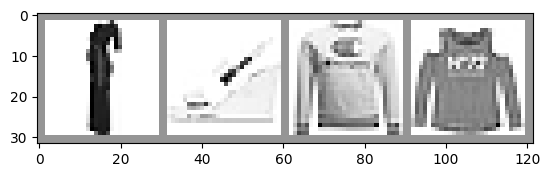

In [ ]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

# Supervised learning

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def train_one_epoch(epoch_index):
    running_loss = 0.0
    last_loss = 0.0
    correct_pred = 0

    for i, data in enumerate(training_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        correct_pred += (predicted == labels).sum().item()

        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000  # loss per batch
            accuracy = 100 * correct_pred / (1000 * labels.size(0))
            print("  batch {} loss: {} accuracy: {}".format(i + 1, last_loss, accuracy))
            running_loss = 0.0
            correct_pred = 0

    return last_loss, accuracy

In [ ]:
EPOCHS = 5
best_vloss = 1000000

for epoch in range(EPOCHS):
    print("EPOCH {}:".format(epoch + 1))

    model.train(True)
    avg_loss, avg_acc = train_one_epoch(epoch)

    running_vloss = 0.0
    correct_val_pred = 0
    total_val_samples = 0
    model.eval()

    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

            _, val_predicted = torch.max(voutputs.data, 1)
            correct_val_pred += (val_predicted == vlabels).sum().item()
            total_val_samples += vlabels.size(0)

    avg_vloss = running_vloss / (i + 1)
    avg_vacc = 100 * correct_val_pred / total_val_samples
    print(
        "LOSS train {} valid {}. Accuracy train {} valid {}".format(
            avg_loss, avg_vloss, avg_acc, avg_vacc
        )
    )

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = "model_{}".format(epoch)
        torch.save(model.state_dict(), model_path)

EPOCH 1:
  batch 1000 loss: 1.8681140997707844 accuracy: 34.3
  batch 2000 loss: 0.9074932682383805 accuracy: 65.125
  batch 3000 loss: 0.7446780684450641 accuracy: 70.6
  batch 4000 loss: 0.6629172960678116 accuracy: 75.025
  batch 5000 loss: 0.5827996153265703 accuracy: 78.175
  batch 6000 loss: 0.5418372967229225 accuracy: 78.725
  batch 7000 loss: 0.5607299359003082 accuracy: 79.775
  batch 8000 loss: 0.5405218497399473 accuracy: 79.75
  batch 9000 loss: 0.49925695107365026 accuracy: 81.8
  batch 10000 loss: 0.5069619642628822 accuracy: 81.025
  batch 11000 loss: 0.4768777026248863 accuracy: 82.3
  batch 12000 loss: 0.4440343756887596 accuracy: 83.7
  batch 13000 loss: 0.42000049106159715 accuracy: 84.9
  batch 14000 loss: 0.4185127798190515 accuracy: 85.25
  batch 15000 loss: 0.41545257340776154 accuracy: 84.7
LOSS train 0.41545257340776154 valid 0.4811961352825165. Accuracy train 84.7 valid 82.19
EPOCH 2:
  batch 1000 loss: 0.4015847086668946 accuracy: 85.0
  batch 2000 loss: 0.4

# Unsupervised learning

In [ ]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28 * 28),
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [ ]:
model = AE()
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-8)
model = model.to(device)

In [ ]:
# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [ ]:
epochs = 20
outputs = []
losses = []
for epoch in range(epochs):
    for image, _ in training_loader:
        image = image.reshape(-1, 28 * 28).to(device)
        reconstructed = model(image)

        loss = loss_function(reconstructed, image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        outputs.append((epochs, image.cpu(), reconstructed.cpu()))
    print(f"Epoch {epoch + 1}/{epochs} completed")

Epoch 1/20 completed
Epoch 2/20 completed
Epoch 3/20 completed
Epoch 4/20 completed
Epoch 5/20 completed
Epoch 6/20 completed
Epoch 7/20 completed
Epoch 8/20 completed
Epoch 9/20 completed
Epoch 10/20 completed
Epoch 11/20 completed
Epoch 12/20 completed
Epoch 13/20 completed
Epoch 14/20 completed
Epoch 15/20 completed
Epoch 16/20 completed
Epoch 17/20 completed
Epoch 18/20 completed
Epoch 19/20 completed
Epoch 20/20 completed


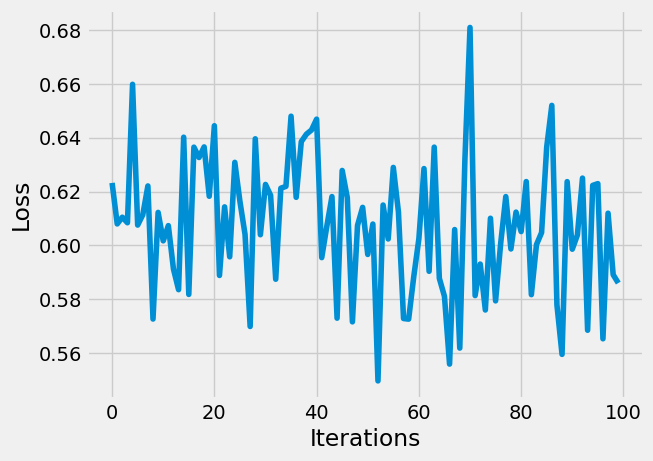

In [ ]:
plt.style.use("fivethirtyeight")
plt.xlabel("Iterations")
plt.ylabel("Loss")


plt.plot(losses[-100:])

In [ ]:
num_images = 10

plt.figure(figsize=(12, 4))
for i in range(num_images):
    # Original image
    original_img = image[i].reshape(28, 28).cpu().detach()
    plt.subplot(2, num_images, i + 1)
    plt.imshow(original_img, cmap="gray")
    plt.axis("off")

    # Reconstructed image
    reconstructed_img = reconstructed[i].reshape(28, 28).cpu().detach()
    plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(reconstructed_img, cmap="gray")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Speech recognition

In [ ]:
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

2.5.0+cu121
2.5.0+cu121
cuda


In [ ]:
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

SPEECH_FILE = "/content/ladies-and-gentlemen-26365.mp3"

In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [ ]:
model = bundle.get_model().to(device)

print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth
100%|██████████| 360M/360M [00:07<00:00, 48.3MB/s]


<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [ ]:
IPython.display.Audio(SPEECH_FILE)

In [ ]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

In [ ]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

In [ ]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

In [ ]:
with torch.inference_mode():
    emission, _ = model(waveform)

In [ ]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [ ]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [ ]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [ ]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

LADIES|AND|GENTLEMEN|PLEASE|FASTEN|YOUR|SEA|BELTS|WE|ARE|EXPECTING|SOME|TURBULENCE|THANK|YOU|LADIES|AND|GENTLEMEN|PLEASE|FASTN|YOUR|SEAT|BELTS|WE|ARE|EXPECTING|SOME|TURBULENCE|THANK|YOU|


# Artificial Neuron Model